In [1]:
# !pip install pillow

In [1]:
%%time
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from concurrent.futures import ThreadPoolExecutor
from sklearn.decomposition import PCA
from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

CPU times: total: 750 ms
Wall time: 816 ms


In [6]:
# 讀取csv檔案
df = pd.read_csv("./data/movie_list_20231126.csv")

In [7]:
# 刪除 revenue 為 0 的資料
df = df[df["revenue"] != 0]

In [4]:
# df = df[df["budget"] != 0]

In [11]:
pd.set_option("display.max_rows", None)
# df.isnull().sum()

# 計算每列的缺失值數量
missing_values = df.isnull().sum()

# 過濾出缺失值不等於零的列
non_zero_missing_values = missing_values[missing_values != 0]

# 顯示統計信息
print(non_zero_missing_values)

overview                      13
tagline                     1537
production_companies         524
production_countries         411
spoken_languages             308
director                      82
writer                       351
cast                         477
oscarNominationCategory     9213
oscarWinnerCategory        10262
cast1                        477
cast2                        601
cast3                        678
cast4                        776
dtype: int64


In [ ]:
df.info

In [ ]:
pd.set_option("display.max_columns", None)
df[df["spoken_languages"].isnull()].head(3)

In [ ]:
x = list(df.head(0))
x

In [ ]:
for j in x:
    count = 0
    for i in df[j]:
        if i == 0:
            count += 1
    print(j, count)

In [40]:
df.dtypes

id                  int64
imdb_id            object
title              object
vote_average      float64
vote_count          int64
                   ...   
cast1              object
cast2              object
cast3              object
cast4              object
isActingWinner     object
Length: 62, dtype: object

In [48]:
Z = [
    "id",
    "vote_average",
    "vote_count",
    "revenue",
    "runtime",
    "budget",
    "popularity",
    "rating",
    "numVotes",
]

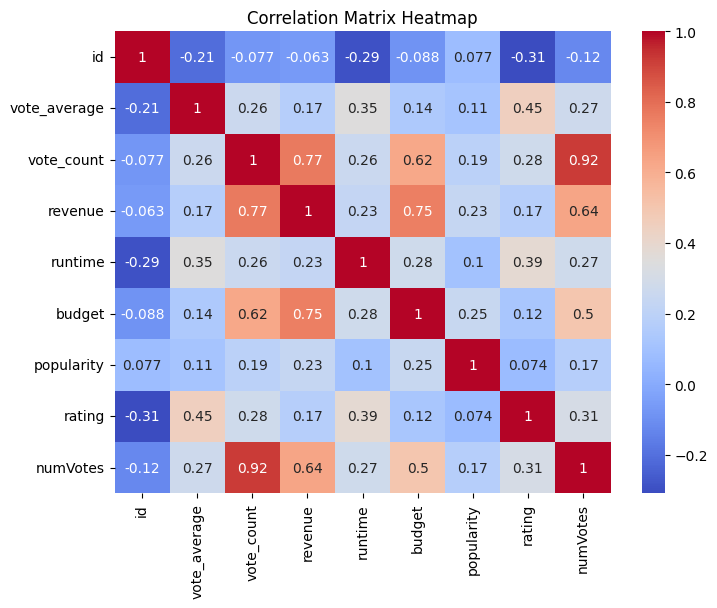

In [38]:
# 創建相關矩陣
#  'category' 依類別上整數標籤
correlation_matrix = df[Z].corr()

# 繪製熱力圖
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [57]:
def evaluate_model(model, X_test, y_test):
    # 進行預測
    y_pred = model.predict(X_test)

    # 計算評估指標
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # 顯示評估結果
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")

In [59]:
def train_random_forest(X, y):
    # 拆分數據集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=87
    )

    # 設定要嘗試的超參數範圍
    param_grid = {
        "n_estimators": [100, 200, 300],  # 樹的數量
        "max_features": ["sqrt", "log2"],  # 劃分時考慮的最大特徵數
        "max_depth": [4, 6, 8, 10],  # 樹的最大深度
        "criterion": ["squared_error"],  # 劃分樹時的評估標準
    }

    # 創建隨機森林模型
    rf_model = RandomForestRegressor(random_state=87)

    # 使用 GridSearchCV 進行超參數搜尋
    grid_search = GridSearchCV(
        estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=3, verbose=2
    )

    # 適用於訓練集
    grid_search.fit(X_train, y_train)

    # 輸出最佳參數和評分
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    print()
    # 可選：返回訓練好的模型和測試數據
    # return grid_search, X_test, y_test
    evaluate_model(grid_search.best_estimator_, X_test, y_test)


# 使用範例：
# 假設 X 和 y 是你的特徵和目標變數
# trained_model, X_test, y_test = train_random_forest(X, y)

In [60]:
for i in range(len(Z)):
    y = df[Z[i]]
    X = df[Z[:i] + Z[i + 1 :]]
    print("y=", Z[i])
    train_random_forest(X, y)
    print("=" * 50)

y= id
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 300}
Best Score: 0.5215132045169496

Mean Squared Error: 29623996777.068745
Mean Absolute Error: 122038.00246031253
R^2 Score: 0.5170454543753363
y= vote_average
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 300}
Best Score: 0.8506821585380054

Mean Squared Error: 0.33745890835166703
Mean Absolute Error: 0.31485788705868767
R^2 Score: 0.8417359352261681
y= vote_count
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}
Best Score: 0.938565918703898

Mean Squared Error: 459467.9740754472
Mean Absolute Error: 272.8893717351063
R^2 Score: 0.9376860357726795
y= revenue
Fitting 3 folds fo

In [19]:
y = df["revenue"]

X = df[
    [
        "vote_average",
        "vote_count",
        "runtime",
        "budget",
        "popularity",
        "rating",
        "numVotes",
    ]
]

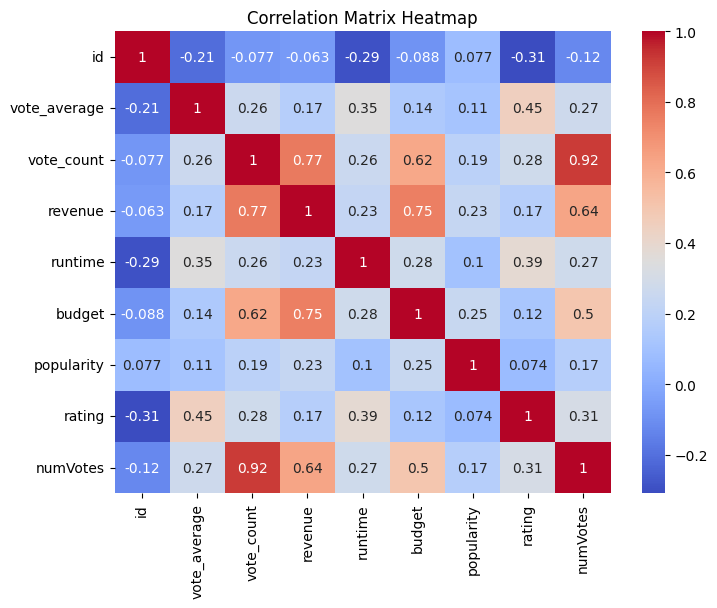

In [32]:
# 創建相關矩陣
#  'category' 依類別上整數標籤
correlation_matrix = df[Z].corr()

# 繪製熱力圖
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [21]:
%%time

# 拆分數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

# 設定要嘗試的超參數範圍
param_grid = {
    'n_estimators': [100, 200, 300],  # 樹的數量
    'max_features': ['sqrt', 'log2'],  # 劃分時考慮的最大特徵數
    'max_depth' : [4, 6, 8, 10],  # 樹的最大深度
    'criterion' :['squared_error']  # 劃分樹時的評估標準
}
# param_grid = {
#     'n_estimators': [100],  # 樹的數量
#     'max_features': ['sqrt'],  # 劃分時考慮的最大特徵數
#     'max_depth' : [4],  # 樹的最大深度
#     'criterion' :['squared_error']  # 劃分樹時的評估標準
# } #能不能用GPU?

# 創建隨機森林模型
rf_model = RandomForestRegressor(random_state=87)

# 使用 GridSearchCV 進行超參數搜尋
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=3, verbose=2)

# 適用於訓練集
grid_search.fit(X_train, y_train)

# 輸出最佳參數和評分
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Best Score: 0.7495070416524564
CPU times: total: 1.94 s
Wall time: 46.7 s


In [23]:
# 回歸評估
y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 4715572784093986.0
Mean Absolute Error: 28220255.88773199
R^2 Score: 0.7606358139177971


In [40]:
%%time
# 級距分類

from sklearn.model_selection import GridSearchCV

y = df['10']  

# 拆分數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

# 設定要嘗試的超參數範圍
param_grid = {
    'n_estimators': [100, 200, 300],  # 樹的數量
    'max_features': ['sqrt', 'log2'],  # 劃分時考慮的最大特徵數
    'max_depth' : [4, 6, 8, 10],  # 樹的最大深度
    'criterion' :['gini', 'entropy']  # 劃分樹時的評估標準
}

# 創建隨機森林模型
rf_model = RandomForestClassifier(random_state=87)

# 使用 GridSearchCV 進行超參數搜尋
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=5, verbose=2)

# 適用於訓練集
grid_search.fit(X_train, y_train)

# 輸出最佳參數和評分
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Best Score: 0.4420445155370402
CPU times: total: 2min 27s
Wall time: 1h 30min 56s


In [41]:
# 使用最佳模型進行預測
y_pred = grid_search.best_estimator_.predict(X_test)

# 計算各項評估指標
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:\n", conf_matrix)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.44637115296279284
Confusion Matrix:
 [[2859 4294    0    1    0    0    0]
 [ 666 8583    7    3    0    0    0]
 [  52 2693   27    9    2    0    0]
 [  17 3156    6  138   26    5    0]
 [  14 2127    3   63   43    4    0]
 [   0  910    0   27   18   11    0]
 [   0  360    0    0    0    0    0]]
Precision: 0.5568040199370831
Recall: 0.44637115296279284
F1 Score: 0.3552533353734615


C:\Users\Chin\.conda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 假設 X 和 y 是您的特徵和目標變量
y = df['4']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 設定要嘗試的超參數範圍 (只選擇一個選項來減少計算時間)
param_grid = {
    'n_estimators': [100],  # 只選擇一個樹的數量
    'max_features': ['sqrt'],  # 只選擇一個劃分時考慮的最大特徵數選項
    'max_depth' : [4],  # 只選擇一個樹的最大深度
    'criterion' :['poisson']  # 只選擇一個劃分樹時的評估標準
}

# 創建隨機森林模型
rf_model = RandomForestRegressor(random_state=87)

# 使用 GridSearchCV 進行超參數搜尋
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=4, verbose=2)

# 適用於訓練集
grid_search.fit(X_train, y_train)

# 輸出最佳參數和評分
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters: {'criterion': 'poisson', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100}
Best Score: 0.05946292709963885
CPU times: total: 52.5 s
Wall time: 2min 41s
